# **East Africa drought study - analysis of model data**

_Model fitting is less stable when using lognormal - carry out transformation separately_

In [94]:
source("../wwa_nonstationary_fitting.r")

prep_window <- function(rc = c(1,1), w = 4, h = 4) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20) }

---
## **Prep & testing**

In [2]:
# load data, fix values for factual & counterfactual climate

df <- read.csv("data/gmst-nino-cpc.csv")

gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- df[df$year == 2022, "nino_ond"]
ondnino_cf <- ondnino_2022

In [75]:
# wrapper function to get bootstrapped confidence intervals for spreadsheet
bootstrap_obs_results <- function(mdl, cov1, cov2, cov1_cf = NA, cov2_cf = NA, seed = 101, nsamp = 1000, dp = 5, convert_logs = T) {

    # create internal function to give required results
    get_mdl_values <- function(mdl, ev, cov1, cov2, cov1_cf = NA, cov2_cf = NA) {
        
        pars <- mdl$par
        
        rp <- 1/map_to_u(mdl, x = event_value, cov1 = cov1, cov2 = cov2)
        rp_cf <- 1/map_to_u(mdl, x = event_value, cov1 = cov1_cf, cov2 = cov2_cf)
        rl_cf <- map_from_u(1/rp, mdl, cov1 = cov1_cf, cov2 = cov2_cf)
        
        # if using log values, convert back to natural units
        if(convert_logs) {
            if(substr(mdl$varnm,1,5) == "log10") {
                ev <- 10^ev
                rl_cf <- 10^rl_cf
            } else if(substr(mdl$varnm,1,3) == "log") {
                ev <- exp(ev)
                rl_cf <- exp(rl_cf)
            }
        }
        c(pars, 
          "dispersion" = unname(pars["sigma0"] / pars["mu0"]),
          "event_magnitude" = ev,
          "return_period" = rp,
          "probability_ratio" = rp_cf/rp,
          "abs_change_in_intensity" = (ev - rl_cf),
          "rel_change_in_intensity" = ((ev - rl_cf) / rl_cf) * 100
         )   
    }
    
    # get best estimate from the observed data
    event_value <- mdl$x[mdl$ev_idx]
    mdl_res <- get_mdl_values(mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    mdl_df <- setNames(data.frame(mdl$x, mdl$cov1, mdl$cov2), c(mdl$varnm, mdl$covnm_1, mdl$covnm_2)) 
    
    # get bootstrap sample
    set.seed(seed)    
    boot_res <- sapply(1:nsamp, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        boot_mdl <- fit_ns(mdl$dist, mdl$type, boot_df, varnm = mdl$varnm, covnm_1 = mdl$covnm_1, covnm_2 = mdl$covnm_2, lower = mdl$lower)
        get_mdl_values(boot_mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    })
    boot_qq <- t(rbind("bestimate" = mdl_res, apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)))
    if(!is.na(dp)) boot_qq <- round(boot_qq, dp)
    return(boot_qq)
}

#### **Check results against Climate Explorer**

In [79]:
# fit test model to log precip - should give same results as Climate Explorer
bootstrap_obs_results(fit_ns("norm", "fixeddisp", df, varnm = "log10pr_ond", covnm_1 = "gmst", lower = T),
                        cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = F)

,bestimate,2.5%,97.5%
mu0,2.11385,1.99395,2.26001
sigma0,0.19262,0.14105,0.24037
alpha,0.07560,-0.16343,0.27828
beta,0.00000,0.00000,0.00000
dispersion,0.09112,0.06683,0.11084
event_magnitude,1.93781,1.93781,1.93781
return_period,9.27779,4.73671,36.10080
probability_ratio,0.51682,0.06253,4.53706
abs_change_in_intensity,0.08141,-0.17479,0.30212
rel_change_in_intensity,4.38518,-8.27384,18.47067


In [80]:
# test same model using lognormal fit - should give comparable disp/RP/PR
bootstrap_obs_results(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T),
                  cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = F)

,bestimate,2.5%,97.5%
mu0,4.86711,-8.581000e-02,5.33036
sigma0,0.44359,3.267500e-01,12.90564
alpha,0.17449,-6.056800e-01,0.77568
beta,0.00000,0.000000e+00,0.00000
dispersion,0.09114,-3.579750e+00,0.42307
event_magnitude,86.65775,8.665775e+01,86.65775
return_period,9.27930,1.118030e+00,35.59413
probability_ratio,0.51613,6.257000e-02,10.59477
abs_change_in_intensity,14.84415,-6.558811e+14,43.76041
rel_change_in_intensity,20.67039,-1.000000e+02,102.39797


#### **Instability in lognormal fit**

_Some instability in the model fit when using lognormal distribution: prefer to use log_pr & convert_

In [76]:
bootstrap_obs_results(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T),
                  cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = T)

,bestimate,2.5%,97.5%
mu0,4.80534,-0.00591,4.601593e+01
sigma0,0.38312,0.30291,1.835417e+02
alpha,0.31110,-148.25073,3.508790e+00
beta,0.18709,-7.72621,2.179950e+00
dispersion,0.07973,-7.74113,1.420148e+06
event_magnitude,86.65775,86.65775,8.665775e+01
return_period,7.26351,1.03753,2.706110e+01
probability_ratio,0.31708,0.06809,1.336318e+02
abs_change_in_intensity,24.57644,-Inf,6.858379e+01
rel_change_in_intensity,39.58751,-100.00000,4.481868e+02


In [77]:
# pr_ond ~ gmst + nino_ond
bootstrap_obs_results(fit_ns("norm", "fixeddisp", df, varnm = "log10pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T),
                  cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = T)

,bestimate,2.5%,97.5%
mu0,2.08734,1.96873,2.20702
sigma0,0.16650,0.12496,0.19207
alpha,0.13447,-0.07215,0.32123
beta,0.07967,0.02650,0.12575
dispersion,0.07977,0.05895,0.09303
event_magnitude,86.65774,86.65774,86.65774
return_period,7.35726,3.69988,30.59830
probability_ratio,0.31701,0.06059,2.08681
abs_change_in_intensity,24.47894,-17.13128,47.55208
rel_change_in_intensity,39.36863,-16.50587,121.60260


In [78]:
# confirm: if we use natural log, we get almost same fitted parameters as using lognormal, but without the model instability
df["lognpr_ond"] <- log(df$pr_ond)
bootstrap_obs_results(fit_ns("norm", "fixeddisp", df, varnm = "lognpr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T),
                  cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = T)

,bestimate,2.5%,97.5%
mu0,4.80631,4.53320,5.08185
sigma0,0.38336,0.28774,0.44230
alpha,0.30973,-0.16611,0.74022
beta,0.18346,0.06101,0.28957
dispersion,0.07976,0.05895,0.09304
event_magnitude,86.65775,86.65775,86.65775
return_period,7.36042,3.70003,30.59794
probability_ratio,0.31685,0.06059,2.08684
abs_change_in_intensity,24.48457,-17.13121,47.57549
rel_change_in_intensity,39.38124,-16.50581,121.73512


---
## **Observations**

In [3]:
source("../wwa_nonstationary_fitting.r")

# load covariate data
df <- merge(read.csv("ts/EA-drought_gmst-smoothed.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst")),
            read.csv("ts/EA-drought_detrended-nino-ond.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "nino_ond")))

# fix covariate values
gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- ondnino_cf <- df[df$year == 2022, "nino_ond"]

### **Results for spreadsheet**

In [84]:
# wrapper function to get bootstrapped confidence intervals for spreadsheet
bootstrap_obs_results <- function(mdl, cov1, cov1_cf, cov2 = NA, cov2_cf = NA, seed = 101, nsamp = 1000, dp = 5, convert_logs = T, spreadsheet_format = T) {

    # create internal function to give required results
    get_mdl_values <- function(mdl, ev, cov1, cov2, cov1_cf = NA, cov2_cf = NA) {
        
        pars <- mdl$par
        
        rp <- 1/map_to_u(mdl, x = event_value, cov1 = cov1, cov2 = cov2)
        rp_cf <- 1/map_to_u(mdl, x = event_value, cov1 = cov1_cf, cov2 = cov2_cf)
        rl_cf <- map_from_u(1/rp, mdl, cov1 = cov1_cf, cov2 = cov2_cf)
        
        # if using log values, convert back to natural units
        if(convert_logs) {
            if(substr(mdl$varnm,1,5) == "log10") {
                ev <- 10^ev
                rl_cf <- 10^rl_cf
            } else if(substr(mdl$varnm,1,3) == "log") {
                ev <- exp(ev)
                rl_cf <- exp(rl_cf)
            }
        }
        c(pars, 
          "dispersion" = unname(pars["sigma0"] / pars["mu0"]),
          "event_magnitude" = ev,
          "return_period" = rp,
          "probability_ratio" = rp_cf/rp,
          "abs_change_in_intensity" = (ev - rl_cf),
          "rel_change_in_intensity" = ((ev - rl_cf) / rl_cf) * 100
         )   
    }
    
    # get best estimate from the observed data
    event_value <- mdl$x[mdl$ev_idx]
    mdl_res <- get_mdl_values(mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    mdl_df <- setNames(data.frame(mdl$x, mdl$cov1, mdl$cov2), c(mdl$varnm, mdl$covnm_1, mdl$covnm_2)) 
    
    # get bootstrap sample
    set.seed(seed)    
    boot_res <- sapply(1:nsamp, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        boot_mdl <- fit_ns(mdl$dist, mdl$type, boot_df, varnm = mdl$varnm, covnm_1 = mdl$covnm_1, covnm_2 = mdl$covnm_2, lower = mdl$lower)
        get_mdl_values(boot_mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    })
    boot_qq <- t(rbind("bestimate" = mdl_res, apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)))
    if(!is.na(dp)) boot_qq <- round(boot_qq, dp)
    
    if(spreadsheet_format) {
        return(c(setNames(boot_qq["dispersion",], c("disp_est", "disp_lower", "disp_upper")),
                                    "event_magnitude" = boot_qq["event_magnitude", "bestimate"],
                                    setNames(boot_qq["return_period",], c("rp_est", "rp_lower", "rp_upper")),
                                    setNames(boot_qq["probability_ratio",], c("pr_est", "pr_lower", "pr_upper")),
                                    setNames(boot_qq["rel_change_in_intensity",], c("rel_DI_est", "rel_DI_lower", "rel_DI_upper")),
                                    setNames(boot_qq["abs_change_in_intensity",], c("abs_DI_est", "abs_DI_lower", "abs_DI_upper"))))
    } else {
        return(boot_qq)
    }
}

In [85]:
pr_ond_res <- do.call("rbind", sapply(c("cpc", "chirps05+centrends01"), function(dsnm) {
    
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_pr-ond_",dsnm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), nsamp = 1000,
                  cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}, simplify = F))
write.csv(pr_ond_res, "res/EA-drought_pr-ond_obs_fitted.csv")

In [86]:
pr_ond_res_gmstonly <- do.call("rbind", sapply(c("cpc", "chirps05+centrends01"), function(dsnm) {
    
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_pr-ond_",dsnm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                  cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}, simplify = F))
write.csv(pr_ond_res_gmstonly, "res/EA-drought_pr-ond_obs_fitted-gmst-only.csv")

In [121]:
pr_mam_res <- do.call("rbind", sapply(c("cpc", "chirps05+centrends01"), function(dsnm) {
    
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_pr-mam_",dsnm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                  cov1 = gmst_2022, cov1_cf = gmst_cf, convert_logs = T)
}, simplify = F))
write.csv(pr_mam_res, "res/EA-drought_pr-mam_obs_fitted.csv")

In [127]:
pr_24_res <- do.call("rbind", sapply(c("cpc", "chirps05+centrends01"), function(dsnm) {
    
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_pr-24_",dsnm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                  cov1 = gmst_2022, cov1_cf = gmst_cf, convert_logs = T)
}, simplify = F))
write.csv(pr_24_res, "res/EA-drought_pr-24_obs_fitted.csv")

### **Plots of trend & return level**

In [48]:
source("../wwa_nonstationary_fitting.r")

# load covariate data
df <- merge(read.csv("ts/EA-drought_gmst-smoothed.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst")),
            read.csv("ts/EA-drought_detrended-nino-ond.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "nino_ond")))

# fix covariate values
gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- ondnino_cf <- df[df$year == 2022, "nino_ond"]

#### **pr_ond ~ gmst + nino_ond**

In [6]:
varnm = "pr-ond"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", ylim = c(1.6,2.8))

        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

In [59]:
# or both models on one axis?
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
    
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    mdl_nino <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)
    mdl_gmst <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,"_both-models.png"), width = 480*1.4, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl_gmst, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, legend_pos = NA)
        plot_gmsttrend(mdl_nino, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", ylim = c(1.6,2.8), legend_pos = NA, add = T, col_main = "darkred", col_rl = "red", lty = "dotted")

        legend("topleft", legend = c("pr_ond ~ gmst", "1-in-6-year event", "1-in-40-year event", "pr_ond ~ gmst + nino", "1-in-6-year event", "1-in-40-year event"),
               ncol = 2, col = c("black", rep("blue", 2), "darkred", rep("red", 2)), lty = rep(1:2, each = 3), lwd = rep(c(2,2,1), 2), bty = "n")
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/rlplot_",varnm,"_",ds_nm,"_both-models.png"), width = 480*1.4, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl_gmst, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip", xlim = c(1,1000), ylim = c(1.6, 2.6), pch = NA, legend_pos = NA)
        plot_returnperiods(mdl_nino, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, add = T, legend_pos = NA, pch = NA, lty = 2)
        
        legend("topright", legend = c("pr_ond ~ gmst (2022 climate)", "pr_ond ~ gmst(counterfactual)", "pr_ond ~ gmst + nino (2022 climate)", "pr_ond ~ gmst + nino (counterfactual)"),
               ncol = 1, col = rep(c("firebrick", "blue"), 2), lty = rep(1:2, each = 2), bty = "n")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

#### **pr_ond ~ gmst**

In [6]:
varnm = "pr-ond"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst",lower = T)

    png(paste0("fig/rlplot_",varnm,"-gmst_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"-gmst_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", ylim = c(1.6,2.8))

        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

#### **pr_mam ~ gmst**

In [12]:
varnm = "pr-mam"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", ylim = c(1.8,2.9), legend_pos = "topleft")

        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

#### **pr_24 ~ gmst**

In [15]:
varnm = "pr-24"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", ylim = c(2.7,3.2), legend_pos = NA)

        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

### **Station data**

In [102]:
source("../wwa_nonstationary_fitting.r")

# load covariate data
df <- merge(read.csv("ts/EA-drought_gmst-smoothed.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst")),
            read.csv("ts/EA-drought_detrended-nino-ond.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "nino_ond")))

# fix covariate values
gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- ondnino_cf <- df[df$year == 2022, "nino_ond"]

#### **Tables of fitted trends**

In [91]:
stn_ond_res <- t(sapply(list.files("ts", pattern = "ond_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), nsamp = 1000,
                          cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}))
write.csv(stn_ond_res, "res/EA-drought_pr-ond_stations_fitted.csv")

In [92]:
stn_mam_res <- t(sapply(list.files("ts", pattern = "mam_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                          cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}))
write.csv(stn_mam_res, "res/EA-drought_pr-mam_stations_fitted.csv")

In [93]:
stn_24_res <- t(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                          cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}))
write.csv(stn_mam_res, "res/EA-drought_pr-24_stations_fitted.csv")

#### **Trend plots**

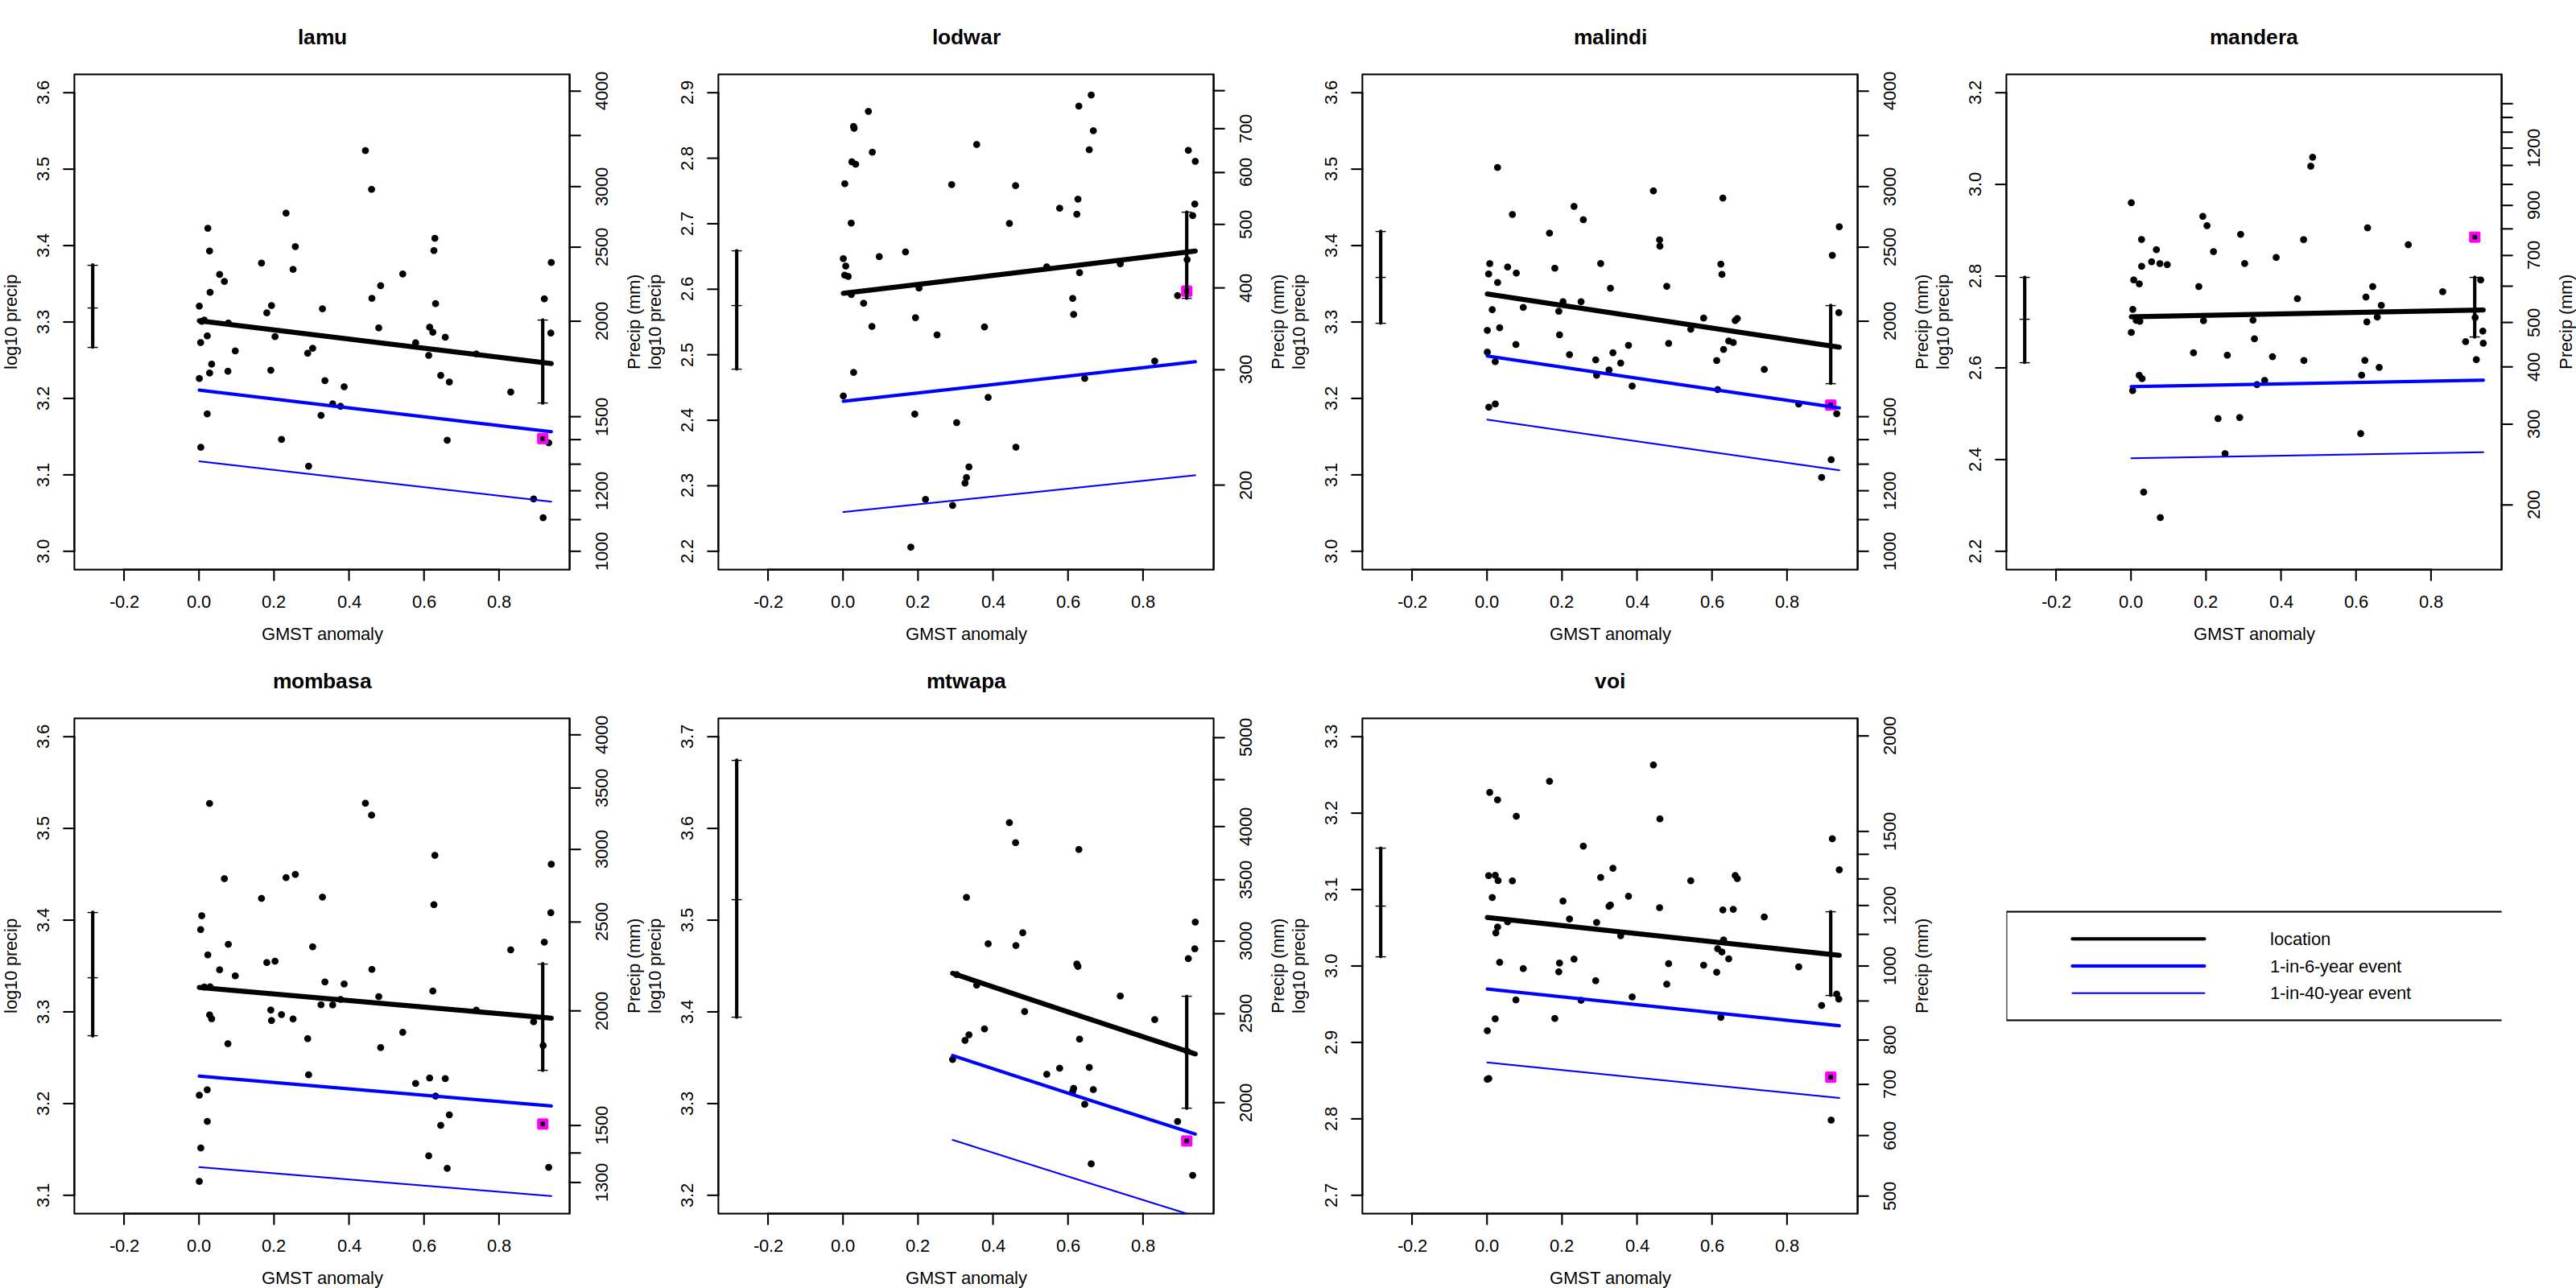

In [111]:
# Trends in GMST
prep_window(c(2,4))
par(mar = c(3.5,3.5,3.5,3.5))
invisible(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    
    plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", legend_pos = NA, main = stn)
    yticks <- c(50,seq(100,1500,100), seq(2000,5000,500))
    axis(4, at = log10(yticks), labels = yticks)
    mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
}))
plot.new()
legend("left", legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", rep("blue", 2)), lwd = c(2,2,1))

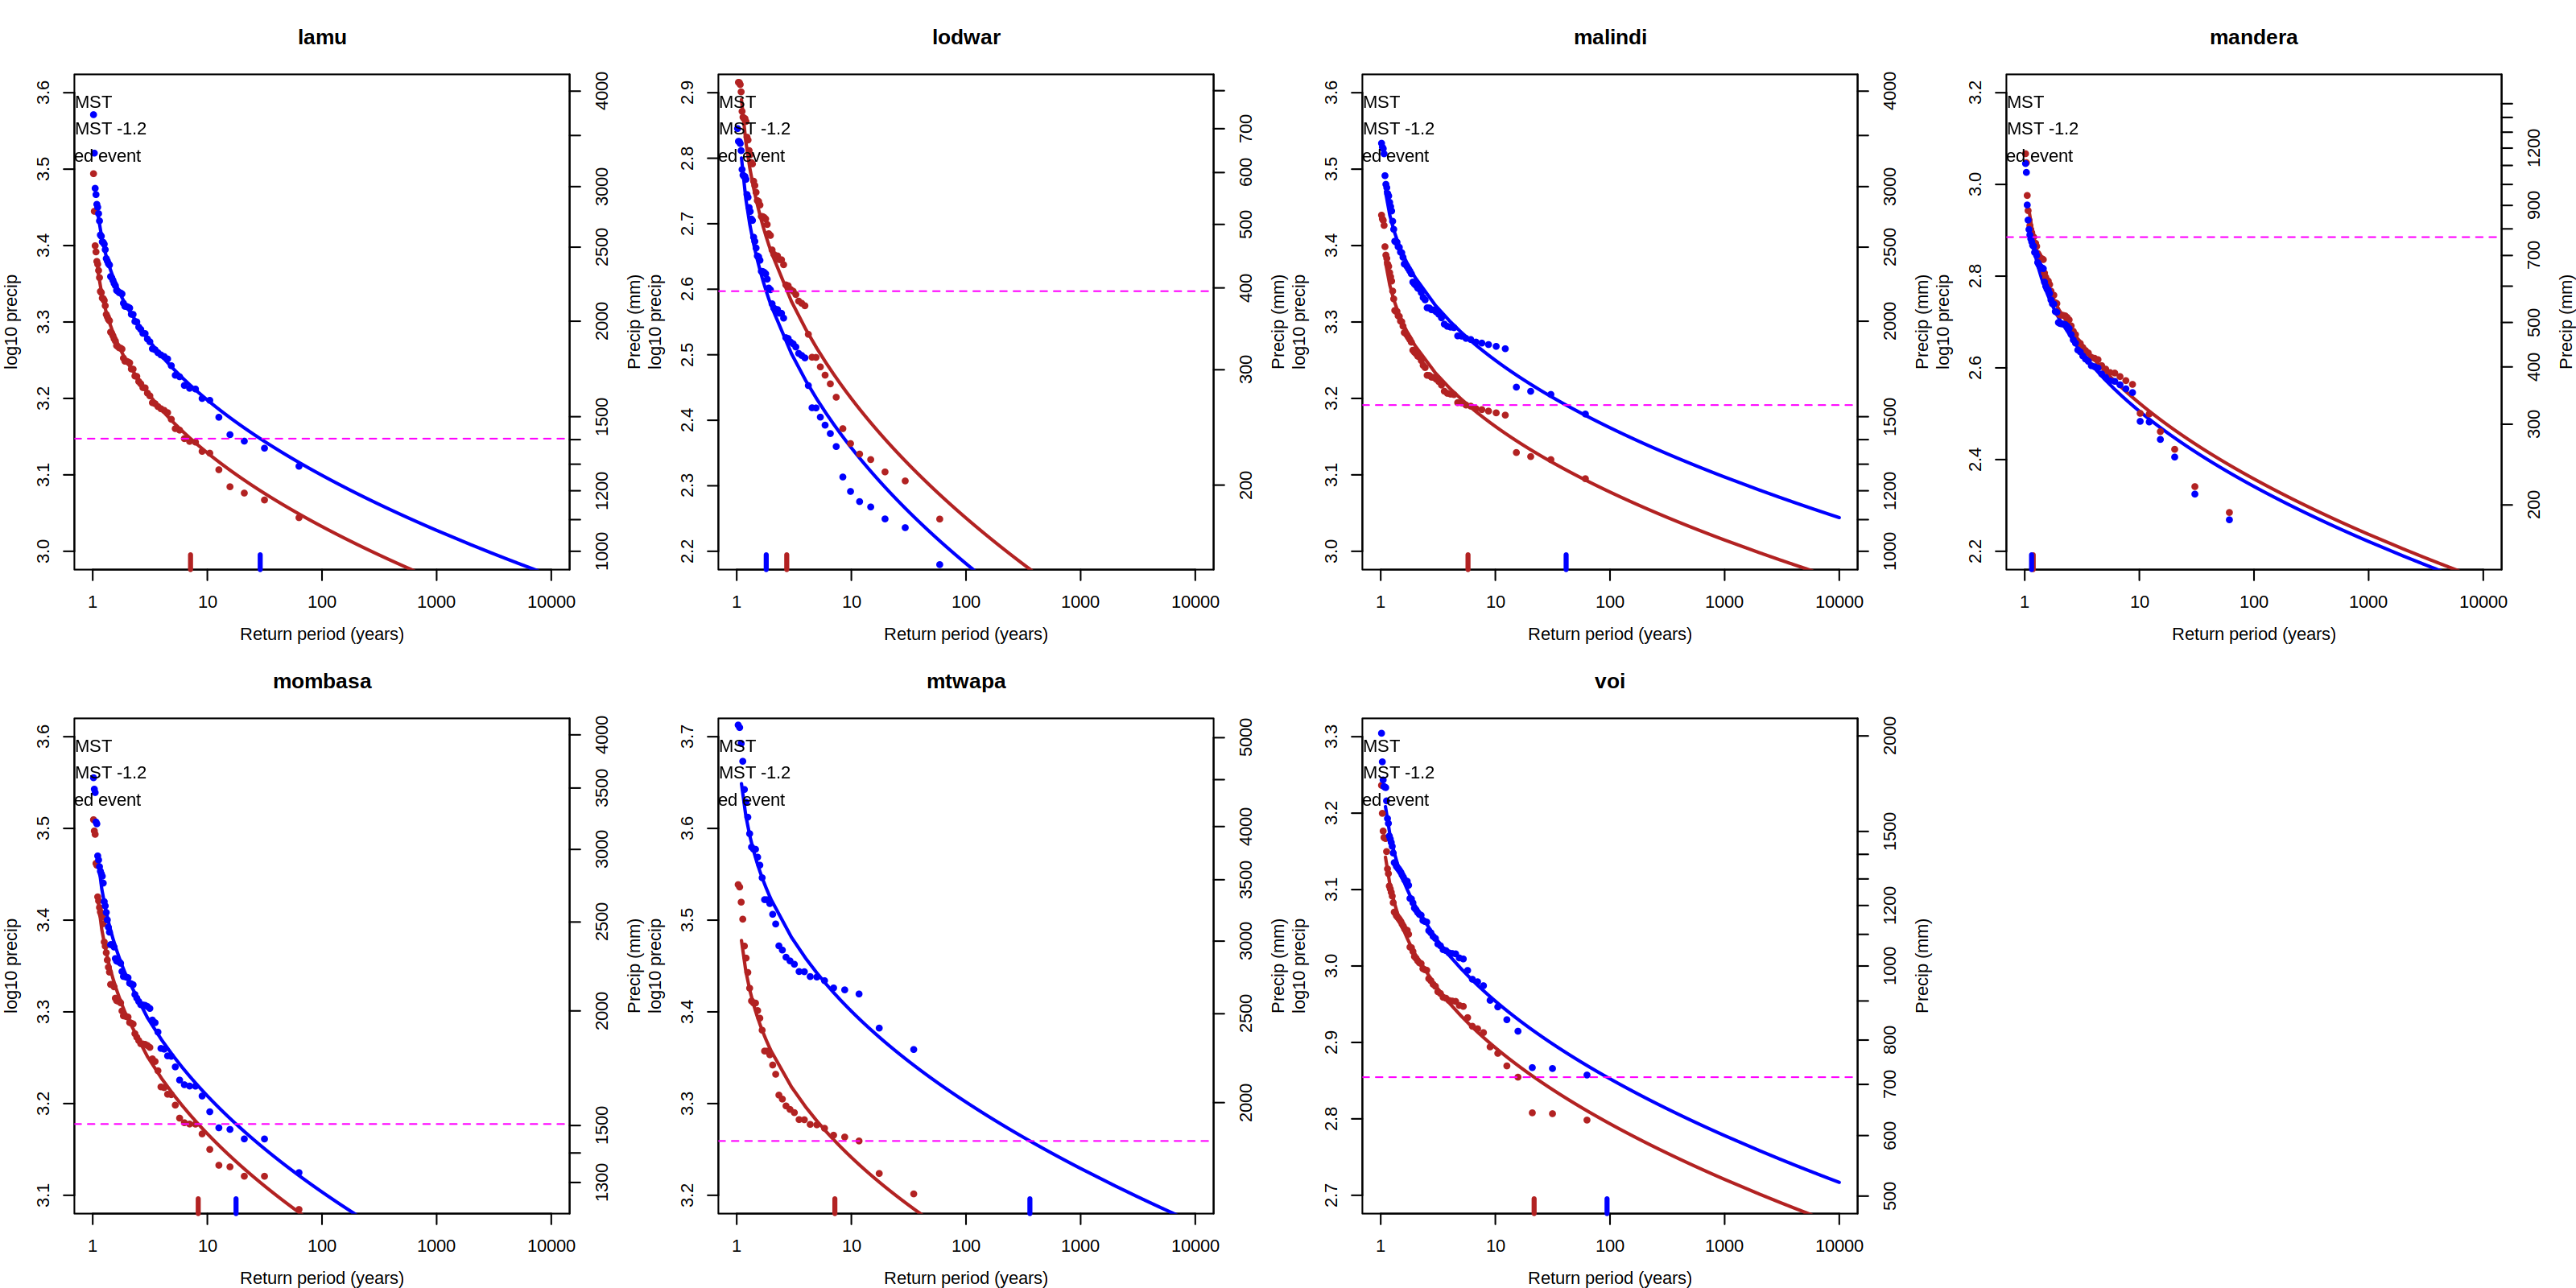

In [110]:
# Return level plots
prep_window(c(2,4))
par(mar = c(3.5,3.5,3.5,3.5))
invisible(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    
    plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip", main = stn)
    
    yticks <- c(50,seq(100,1500,100), seq(2000,5000,500))
    axis(4, at = log10(yticks), labels = yticks)
    mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    
}))

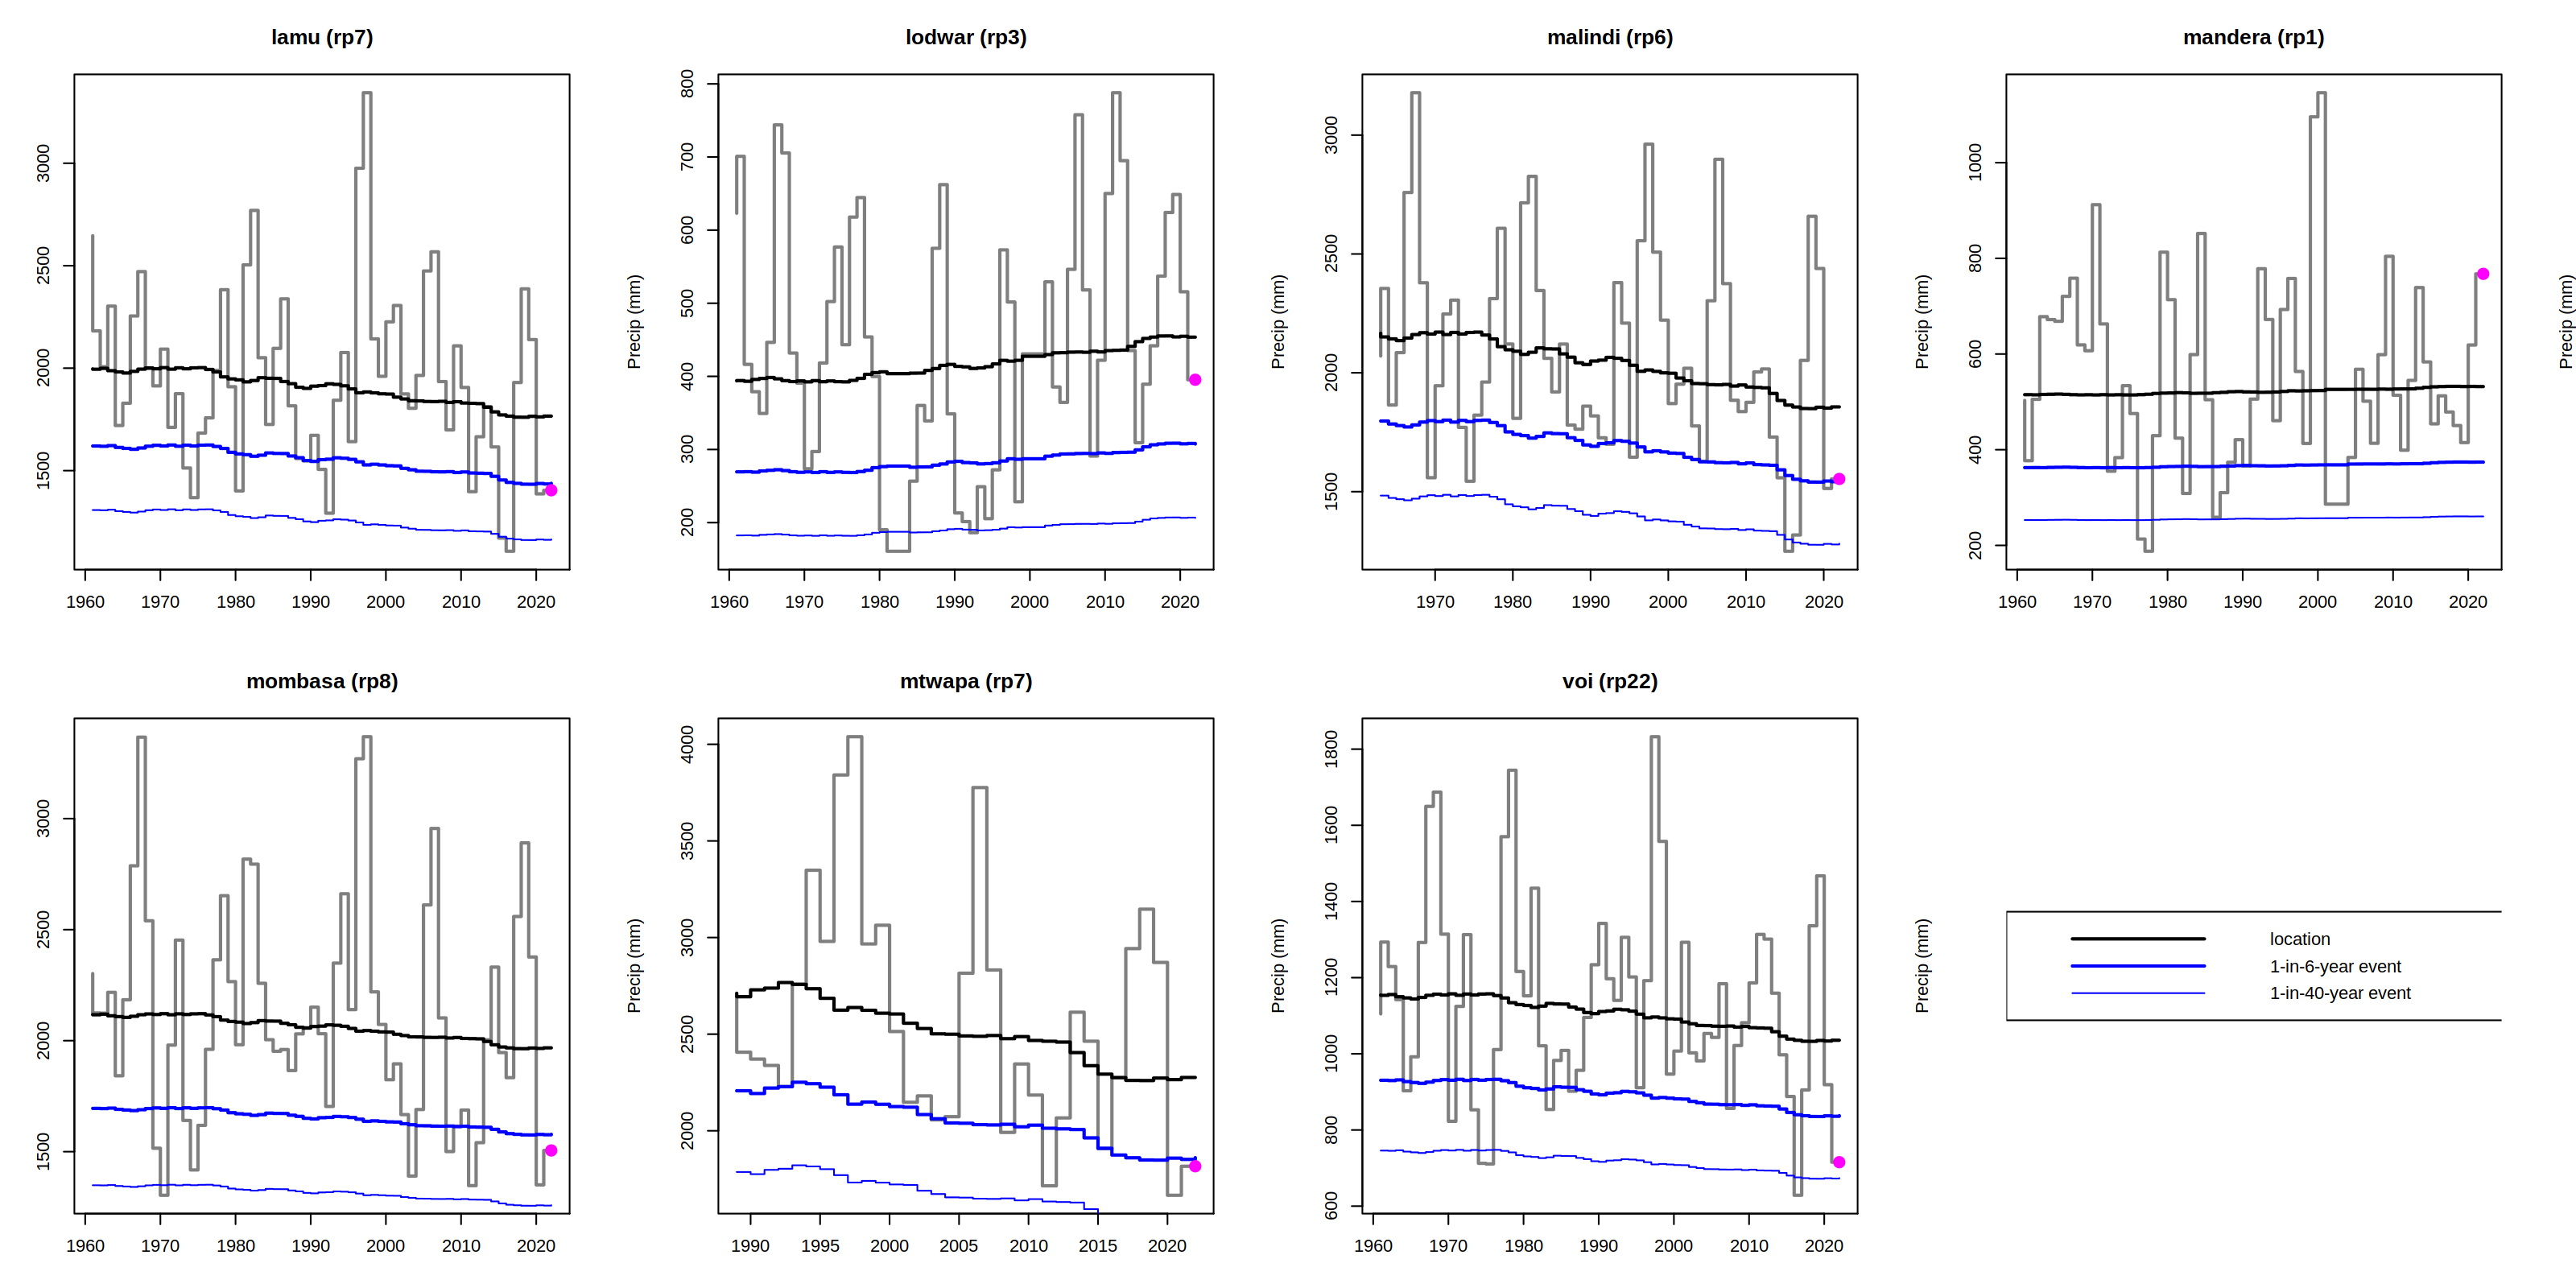

In [140]:
# Trends over time

prep_window(c(2,4))
par(mar = c(3.5,3.5,3.5,3.5))
invisible(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    rp_2022 <- 1/map_to_u(mdl)[mdl$ev_idx]
    
    plot(pr_df[,c("year", "precip")], type = "S", lwd = 2, xlab = "", ylab = "", col = adjustcolor("black", alpha = 0.5), main = paste0(stn, " (rp", round(rp_2022,0),")"))
    lines(pr_df$year, 10^ns_pars(mdl)$loc, type = "S", lwd = 2, col = "black")
    lines(pr_df$year, 10^map_from_u(1/6, mdl, cov1 = mdl$cov1), col = "blue", lwd = 2, type = "s")
    lines(pr_df$year, 10^map_from_u(1/40, mdl, cov1 = mdl$cov1), col = "blue", lwd = 1, type = "s")
    
    points(2022, pr_df$precip[pr_df$year == 2022], col = "magenta", pch = 20, cex = 2)
    
    yticks <- c(50,seq(100,1500,100), seq(2000,5000,500))
    axis(4, at = log10(yticks), labels = yticks)
    mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
}))
plot.new()
legend("left", legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", rep("blue", 2)), lwd = c(2,2,1))

---
## **Models**

In [8]:
source("../wwa_nonstationary_fitting.r")

spreadsheet_results <- function(df, dist, fittype, varnm, covnm_1, covnm_2 = NA, cov1_2022, cov1_hist, cov1_fut, cov2_2022 = 0, cov2_hist = 0, cov2_fut = 0,
                                lower = F, rp = 10, delta_relative = T, nsamp = 1000, seed = 1) {
    
    # FUNCTION TO CARRY OUT ALL ATTRIBUTION RUNS & PRODUCE RESULTS IN SPREADSHEET-FRIENDLY FORM
    
    set.seed(seed)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # FIT MODEL to three different subsets: for evaluation, attribution & projection
    
    df_eval <- df[df$year >= 1979 & df$year <= 2022,]
    df_attr <- df[df$year <= 2022,]
    df_proj <- df[df$year <= 2050,]
    
    mdl_eval <- fit_ns(dist, fittype, df_eval, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    mdl_attr <- fit_ns(dist, fittype, df_attr, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    mdl_proj <- fit_ns(dist, fittype, df_proj, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## EVALUATION (get model parameters)
    
    disp_eval <- mdl_eval$par["sigma0"] / mdl_eval$par["mu0"]
    boot_eval <- sapply(1:nsamp, function(i) {
        
        boot_df <- df_eval[sample(1:nrow(df_eval), nrow(df_eval), replace = T),]
        boot_mdl <- fit_ns(mdl_eval$dist, mdl_eval$type, boot_df, varnm = mdl_eval$varnm, covnm_1 = mdl_eval$covnm_1, covnm_2 = mdl_eval$covnm_2, lower = mdl_eval$lower)
        boot_mdl$par["sigma0"] / boot_mdl$par["mu0"]
    })
    ci_eval <- setNames(c(disp_eval, quantile(boot_eval, c(0.025, 0.975))),
                        c("disp_est", "disp_lower", "disp_upper"))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## ATTRIBUTION (get event value, PR & DI)
    
    logrl_2022 <- map_from_u(1/rp, mdl_attr, cov1 = cov1_2022, cov2 = cov2_2022)
    logrl_cf <- map_from_u(1/rp, mdl_attr, cov1 = cov1_hist, cov2 = cov2_hist)
    
    rl_2022 <- 10^logrl_2022
    
    pr_eval <- prob_ratio(mdl_attr, logrl_2022, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist)
    dI_eval <- Delta_I(mdl_attr, rp, cov1 = cov1_2022, cov1_cf = cov1_hist, relative = delta_relative)
    
    boot_attr <- sapply(1:nsamp, function(i) {
        
        boot_df <- df_attr[sample(1:nrow(df_attr), nrow(df_attr), replace = T),]
        boot_mdl <- fit_ns(mdl_attr$dist, mdl_attr$type, boot_df, varnm = mdl_attr$varnm, covnm_1 = mdl_attr$covnm_1, covnm_2 = mdl_attr$covnm_2, lower = mdl_attr$lower)
        
        boot_pr <- prob_ratio(boot_mdl, logrl_2022, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist)
        boot_di <- Delta_I(boot_mdl, 10, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist, relative = delta_relative)
        
        c("PR" = boot_pr, "DI" = boot_di)
    })
    ci_attr <- rbind("est" = c(pr_eval, dI_eval), apply(boot_attr, 1, quantile, c(0.025, 0.975)))
    ci_attr <- unlist(lapply(colnames(ci_attr), function(cnm) setNames(ci_attr[,cnm], paste("attr", cnm, c("est", "lower", "upper"), sep = "_"))))
                          
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## PROJECTION (get PR & DI)

    pr_proj <- prob_ratio(mdl_proj, logrl_2022, cov1 = cov1_2022, cov1_cf = cov1_fut, cov2 = cov2_2022, cov2_cf = cov2_fut)
    dI_proj <- Delta_I(mdl_proj, 10, cov1 = cov1_2022, cov1_cf = cov1_fut, relative = delta_relative)
                             
    boot_proj <- sapply(1:nsamp, function(i) {
        
        boot_df <- df_proj[sample(1:nrow(df_proj), nrow(df_proj), replace = T),]
        boot_mdl <- fit_ns(mdl_proj$dist, mdl_proj$type, boot_df, varnm = mdl_proj$varnm, covnm_1 = mdl_proj$covnm_1, covnm_2 = mdl_proj$covnm_2, lower = mdl_proj$lower)
        
        boot_pr <- prob_ratio(boot_mdl, logrl_2022, cov1 = cov1_2022, cov1_cf = cov1_fut, cov2 = cov2_2022, cov2_cf = cov2_fut)
        boot_di <- Delta_I(boot_mdl, 10, cov1 = cov1_2022, cov1_cf = cov1_fut, cov2 = cov2_2022, cov2_cf = cov2_fut, relative = delta_relative)
        
        c("PR" = boot_pr, "DI" = boot_di)
    })
    ci_proj <- rbind("est" = c(pr_proj, dI_proj), apply(boot_proj, 1, quantile, c(0.025, 0.975)))
      
    # invert
    ci_proj[,"PR"] <- 1/ci_proj[c(1,3,2),"PR"]
    ci_proj[,"DI"] <- -ci_proj[c(1,3,2),"DI"]   
                             
    ci_proj <- unlist(lapply(colnames(ci_proj), function(cnm) setNames(ci_proj[,cnm], paste("proj", cnm, c("est", "lower", "upper"), sep = "_"))))
                             
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                             
    # t(setNames(data.frame(c(ci_eval, "rp_value" = rl_2022, ci_attr, ci_proj)), gsub(".dat", "", gsub(".+pr-mam_", "", fnm))))      
    t(data.frame(c(ci_eval, "rp_value" = rl_2022, ci_attr, ci_proj)))     
}



### **CORDEX**

In [72]:
# MAM (long rains): 10-year event

rp_mam <- 10

cordex_mam_res <- sapply(list.files("ts", pattern = "pr-mam_AFR", full.names = T), function(fnm) {
    
    if(grepl("HadGEM2-ES_r1_RegCM4-3", fnm)) {return(rep(NA, 16))}
    
    gmst_fnm <- list.files("../00_gsat", pattern = paste0(strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],"i"), full.names = T)
    if(length(gmst_fnm) == 0) {
        return(rep(NA, 16))
    } else {
        
        # load necessary data
        gmst <- read.csv(gmst_fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst"))
        pr <- read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "pr"))
        df <- merge(gmst, pr)
        df["log10pr"] <- log10(df$pr)   # fit models to log precip, convert back at the end (more stable model fitting)
        
        # covariates defining current, past & future climates
        gmst_2022 <- gmst[gmst$year == 2022, "gmst"]
        gmst_hist <- gmst_2022 - 1.2
        gmst_fut <- gmst_2022 + 0.8
        
        nino_2022 <- nino_hist <- nino_fut <- 0    # dummy variables for now (mainly so I don't forget them later)
        
        data.frame(spreadsheet_results(df, "norm", "fixeddisp", varnm = "log10pr", covnm_1 = "gmst", lower = T, rp = rp_mam, delta_relative = T, nsamp = 1000,
                                       cov1_2022 = gmst_2022, cov1_hist = gmst_hist, cov1_fut = gmst_fut, 
                                       cov2_2022 = nino_2022, cov2_hist = nino_hist, cov2_fut = nino_fut))
    }
}, simplify = F)
cordex_mam_res <- do.call("rbind", cordex_mam_res)
rownames(cordex_mam_res) <- gsub(".dat", "", gsub(".+pr-mam_", "", rownames(cordex_mam_res)))

write.csv(cordex_mam_res, "res/EA-drought_pr-mam_cordex_fitted.csv")

In [ ]:
# 2-year accumulated precip: 20-year event

rp_pr24 <- 20

cordex_pr24_res <- sapply(list.files("ts", pattern = "pr-24_AFR", full.names = T), function(fnm) {
    
    if(grepl("HadGEM2-ES_r1_RegCM4-3", fnm)) {return(rep(NA, 16))}
    
    gmst_fnm <- list.files("../00_gsat", pattern = paste0(strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],"i"), full.names = T)
    if(length(gmst_fnm) == 0) {
        return(rep(NA, 16))
    } else {
        
        # load necessary data
        gmst <- read.csv(gmst_fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst"))
        pr <- read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "pr"))
        df <- merge(gmst, pr)
        df["log10pr"] <- log10(df$pr)   # fit models to log precip, convert back at the end (more stable model fitting)
        
        # covariates defining current, past & future climates
        gmst_2022 <- gmst[gmst$year == 2022, "gmst"]
        gmst_hist <- gmst_2022 - 1.2
        gmst_fut <- gmst_2022 + 0.8
        
        nino_2022 <- nino_hist <- nino_fut <- 0    # dummy variables for now (mainly so I don't forget them later)
        
        data.frame(spreadsheet_results(df, "norm", "fixeddisp", varnm = "log10pr", covnm_1 = "gmst", lower = T, rp = rp_pr24, delta_relative = T, nsamp = 1000,
                                       cov1_2022 = gmst_2022, cov1_hist = gmst_hist, cov1_fut = gmst_fut, 
                                       cov2_2022 = nino_2022, cov2_hist = nino_hist, cov2_fut = nino_fut))
    }
}, simplify = F)
cordex_pr24_res <- do.call("rbind", cordex_pr24_res)
rownames(cordex_pr24_res) <- gsub(".dat", "", gsub(".+pr-24_", "", rownames(cordex_pr24_res)))

write.csv(cordex_pr24_res, "res/EA-drought_pr-24_cordex_fitted.csv")

In [17]:
# OND (short rains): 10-year event

rp_ond <- 5

cordex_ond_res <- sapply(list.files("ts", pattern = "pr-ond_AFR", full.names = T), function(fnm) {
    
    if(grepl("HadGEM2-ES_r1_RegCM4-3", fnm)) {return(rep(NA, 16))}
    
    gmst_fnm <- list.files("ts", paste0("gsat_",strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],"i"), full.names = T)
    nino_fnm <- list.files("ts", paste0("nino-ond_",strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],".dat"), full.names = T)

    if((length(gmst_fnm) == 0) || (length(nino_fnm) == 0)) {
        return(rep(NA, 16))
    } else {
        
        # load necessary data
        gmst <- read.csv(gmst_fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst"))
        nino <- read.csv(nino_fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "nino_ond"))
                
        pr <- read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), pr)
        df["log10pr"] <- log10(df$pr)   # fit models to log precip, convert back at the end (more stable model fitting)
        
        # covariates defining current, past & future climates
        gmst_2022 <- gmst[gmst$year == 2022, "gmst"]
        gmst_hist <- gmst_2022 - 1.2
        gmst_fut <- gmst_2022 + 0.8
        
        if(max(df$year) < 2022) {
            nino_2022 <- nino_hist <- nino_fut <- 0    # fix Nino condition at neutral
        } else {
            nino_2022 <- nino_hist <- nino_fut <- nino[nino$year == 2022, "nino_ond"]    # fix Nino condition at 2022 levels
        }
                
        data.frame(spreadsheet_results(df, "norm", "fixeddisp", varnm = "log10pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T, rp = rp_ond, delta_relative = T, nsamp = 5,
                                       cov1_2022 = gmst_2022, cov1_hist = gmst_hist, cov1_fut = gmst_fut, 
                                       cov2_2022 = nino_2022, cov2_hist = nino_hist, cov2_fut = nino_fut))
    }
}, simplify = F)
cordex_ond_res <- do.call("rbind", cordex_ond_res)
rownames(cordex_ond_res) <- gsub(".dat", "", gsub(".+pr-ond_", "", rownames(cordex_ond_res)))

write.csv(cordex_ond_res, "res/EA-drought_pr-ond_cordex_fitted.csv")

,disp_est,disp_lower,disp_upper,rp_value,attr_PR_est,attr_PR_lower,attr_PR_upper,attr_DI_est,attr_DI_lower,attr_DI_upper,proj_PR_est,proj_PR_lower,proj_PR_upper,proj_DI_est,proj_DI_lower,proj_DI_upper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFR-22_CanESM2_r1_CanRCM4,0.03717361,0.02992207,0.03826779,2.265112e+02,0.3618084,0.21713078,0.3382457,21.6084732,22.18477817,31.336699,0.43422243,0.439837874,0.4827341,10.1718524,8.8450318,10.2887371
AFR-22_HadGEM2-ES_r1_CCLM5-0-15,0.08849244,0.06301694,0.09708051,6.106256e+01,1.5225003,0.85147332,1.9258698,-12.5577636,-17.15409393,4.356593,1.06151184,1.033353117,1.2166422,-1.9092205,-6.7343036,-1.1686854
AFR-22_HadGEM2-ES_r1_RegCM4-7,0.04400484,0.03233644,0.04709746,1.876124e+02,0.8341894,0.49303970,1.2551187,3.5569014,-3.92878987,15.591914,0.95941030,0.773754630,1.1655601,0.8040727,-2.8742035,5.4363447
AFR-22_HadGEM2-ES_r1_REMO2015,0.08530732,0.05307525,0.08753882,9.421921e+01,0.9754634,0.43818101,1.7925685,0.7320147,-13.54237405,20.333370,1.14779847,1.017547533,1.3374832,-4.9250345,-10.3285765,-0.6811859
AFR-22_MPI-ESM-LR_r1_CCLM5-0-15,0.10204617,0.08637138,0.11431855,1.166287e+02,0.3243220,0.08529806,0.6108674,74.4100563,35.09033871,141.297629,0.31776361,0.085134664,0.8424731,32.3024022,5.4523933,50.6070254
AFR-22_MPI-ESM-LR_r1_REMO2015,0.07978863,0.05855586,0.07794366,1.906863e+02,0.2110169,0.01554726,0.2556960,146.2856527,106.62612504,296.865130,0.06186326,0.001030389,0.2482191,49.1574819,37.9046880,72.8232857
AFR-22_MPI-ESM-MR_r1_RegCM4-7,0.04816554,0.02875572,0.05237390,2.339867e+02,0.2416238,0.09651404,0.8568404,66.8701441,6.81875009,87.056947,0.13134971,0.119088534,0.6283363,30.3058553,8.8933651,33.8905041
AFR-22_NorESM1-M_r1_CCLM5-0-15,0.07588430,0.06093683,0.07403096,1.919422e+02,0.2881120,0.24805573,0.8856567,64.4215215,6.68599865,64.199210,0.23754326,0.040657821,0.6157955,29.3747101,14.2431918,44.0963980
AFR-22_NorESM1-M_r1_RegCM4-7,0.04287878,0.03427618,0.03940798,4.111129e+02,0.2303752,0.11613078,0.5088452,66.0625436,26.65441031,104.111497,0.09964562,0.009001711,0.0559156,29.9726812,35.0555800,44.7841195
